# 1) Setup colab runtime environment

# 1.1. Download Dataset

In [1]:
!git clone https://github.com/balarcode/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 3037, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 3037 (delta 42), reused 9 (delta 9), pack-reused 2975 (from 2)
Receiving objects: 100% (3037/3037), 433.91 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (274/274), done.
Updating files: 100% (2498/2498), done.


# 1.2. Common Imports

In [2]:
import sys
sys.path.append('/content/deep-learning/computer_vision/image_classification/data')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch # PyTorch machine learning framework
import torch.nn.functional as F # PyTorch module that contains common neural network functions
import timm # PyTorch image model library
from torchvision import transforms as T, datasets # PyTorch package for computer vision
from torch.utils.data import DataLoader # PyTorch DataLoader
from torchvision.utils import make_grid # torchvision utility for making a grid of images
from torchsummary import summary # PyTorch summary module to show a detailed breakdown of the model
from tqdm.notebook import tqdm # Jupyter Notebook progress bar decorator for iterators

# 2) Setup Configuration

In [4]:
# Input dataset (training, validation and test)
DATA_DIR = '/content/deep-learning/computer_vision/image_classification/data/'
TRAINING_DIR = DATA_DIR + 'training'               # Training dataset
VALIDATION_DIR = DATA_DIR + 'validation'           # Validation dataset
TEST_DIR = DATA_DIR + 'test'                       # Test dataset

# Neural network settings
EPOCHS = 15                                        # Number of epochs used for training & fitting the model
LR = 0.001                                         # Learning rate
BATCH_SIZE = 16                                    # Batch size
MODEL_NAME = 'tf_efficientnet_b4_ns'               # Model name
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Device to use for training

# Other configuration
IMG_SIZE = 224                                     # Used for resizing the images

print("Training Device: {}".format(DEVICE))

Training Device: cuda


# 3) Image Transformation (Augmentations)

In [5]:
# Function to display the images from respective datasets
def display_image(image, label, get_denormalize=True):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]) # Values from pre-trained ImageNet model
    std = torch.FloatTensor([0.229, 0.224, 0.225]) # Values from pre-trained ImageNet model

    if get_denormalize == True:
        image = (image * std) + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)

In [6]:
# Image transformation applied to training dataset images in the following sequence
training_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.RandomRotation(degrees=[-20, +20]),
    T.ToTensor(), # ToTensor is used to convert input image (h, w, c) into a PyTorch tensor (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Values from pre-trained ImageNet model
    ])

# Image transformation applied to validation dataset images in the following sequence
validation_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor(), # ToTensor is used to convert input image (h, w, c) into a PyTorch tensor (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Values from pre-trained ImageNet model
    ])

# Image transformation applied to test dataset images in the following sequence
test_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor(), # ToTensor is used to convert input image (h, w, c) into a PyTorch tensor (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Values from pre-trained ImageNet model
    ])

In [7]:
training_dataset = datasets.ImageFolder(root=TRAINING_DIR, transform=training_transform)
validation_dataset = datasets.ImageFolder(root=VALIDATION_DIR, transform=validation_transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

print("Training Dataset Size : {}".format(len(training_dataset)))
print("Validation Dataset Size : {}".format(len(validation_dataset)))
print("Test Dataset Size : {}".format(len(test_dataset)))

Training Dataset Size : 1060
Validation Dataset Size : 16
Test Dataset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}




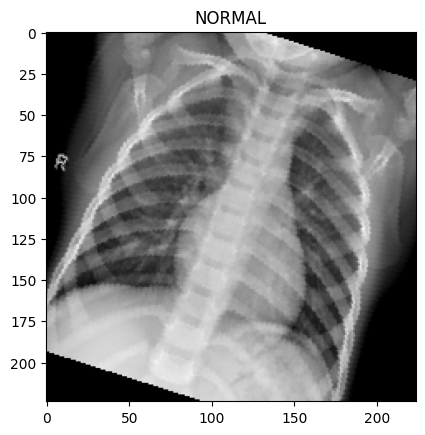

In [8]:
image, label = training_dataset[2]
print(training_dataset.class_to_idx)
print("\n")
CLASS_NAME = ['NORMAL', 'PNEUMONIA']

display_image(image, CLASS_NAME[label])

{'NORMAL': 0, 'PNEUMONIA': 1}




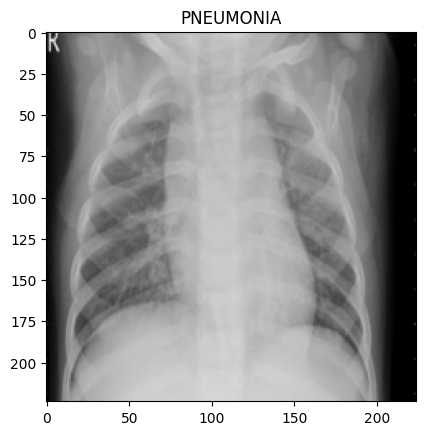

In [9]:
image, label = validation_dataset[10]
print(validation_dataset.class_to_idx)
print("\n")
CLASS_NAME = ['NORMAL', 'PNEUMONIA']

display_image(image, CLASS_NAME[label])

# 4) Load Dataset into Batches

In [10]:
# Function to display a grid of images
def display_grid(image, title=None):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]) # Values from pre-trained ImageNet model
    std = torch.FloatTensor([0.229, 0.224, 0.225]) # Values from pre-trained ImageNet model

    image = (image * std) + mean
    image = np.clip(image, 0, 1)

    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)

In [11]:
trainingloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the batches
validationloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print("Number of Batches in Training DataLoader : {}".format(len(trainingloader)))
print("Number of Examples in Training DataLoader : {}".format(len(trainingloader.dataset)))
print("Number of Batches in Validation DataLoader : {}".format(len(validationloader)))
print("Number of Examples in Validation DataLoader : {}".format(len(validationloader.dataset)))
print("Number of Batches in Test DataLoader : {}".format(len(testloader)))
print("Number of Examples in Test DataLoader : {}".format(len(testloader.dataset)))

Number of Batches in Training DataLoader : 67
Number of Examples in Training DataLoader : 1060
Number of Batches in Validation DataLoader : 1
Number of Examples in Validation DataLoader : 16
Number of Batches in Test DataLoader : 39
Number of Examples in Test DataLoader : 624


torch.Size([16, 3, 224, 224])
torch.Size([16])




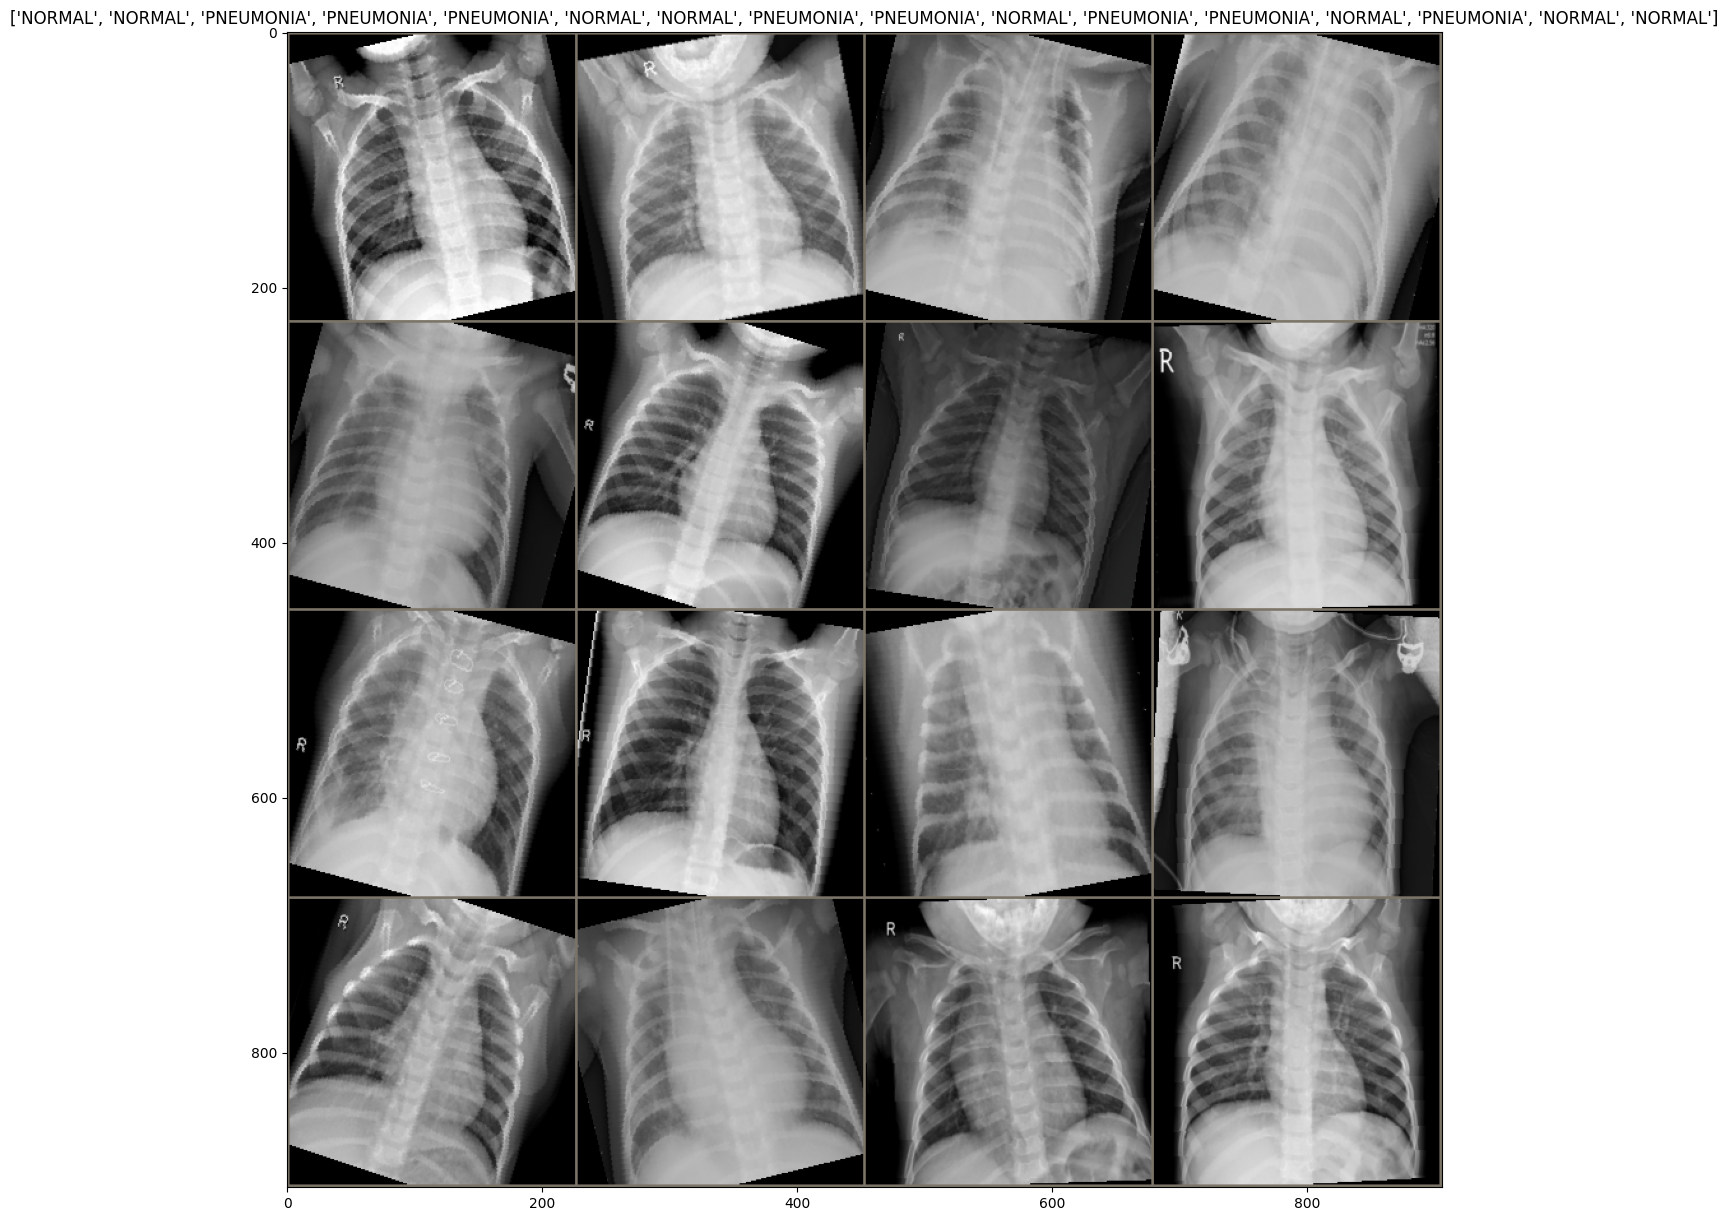

In [13]:
# Load one batch from training dataset and display the images in a grid
dataiter = iter(trainingloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)
print("\n")

display_grid(make_grid(images, nrow=4), title=[CLASS_NAME[idx] for idx in labels])

# 5) Fine-Tune EfficientNet Model

In [14]:
# Use the MODEL_NAME available in timm along with model's pre-trained weights on ImageNet dataset
model = timm.create_model(MODEL_NAME, pretrained=True)
model

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [15]:
# Fine-tune the classifier layer i.e. the last layer of the model
# The last layer being the classifier is fine-tuned to the project application defined in this file.
# Out_features of the last linear layer is set to '2' to define a multi-class classifier.
# Finally, use cross-entropy loss function and apply softmax activation function.
# NOTE: Sigmoid activation function along with binary cross entropy loss function will be needed for binary classification problem.
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=1792, out_features=625),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3), # Regularization technique to prevent overfitting
    torch.nn.Linear(in_features=625, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=2)
)

# Print the fine-tuned model architecture
model
model.to(DEVICE)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [16]:
# Use torchsummary for a detailed breakdown of the fine-tuned model
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
          Identity-9         [-1, 48, 112, 112]               0
           Conv2d-10             [-1, 12, 1, 1]             588
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 48, 1, 1]             624
          Sigmoid-13             [-1, 48, 1, 1]               0
    SqueezeExcite-14         [-1, 48, 1

# 6) Build a Classification Model

In [17]:
# Function to compute accuracy of the prediction from the model (i.e. after forward pass from the model)
def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1) # Pass through a softmax activation function
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = (top_class == y_true.view(*top_class.shape))
    return torch.mean(equals.type(torch.FloatTensor))

In [18]:
class ClassificationModel():
    def __init__(self, loss_function, optimizer, scheduler):
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler

    def training_batch_loop(self, model, trainingloader):
        training_accuracy = 0
        training_loss = 0
        for images, labels in tqdm(trainingloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE) # Ground truth labels

            # Forward pass
            logits = model(images) # The raw output logits from the model further needs to be passed into a softmax activation function
            loss = self.loss_function(logits, labels)

            # Backward pass + optimization
            self.optimizer.zero_grad() # Initialize the gradients to be zeros
            loss.backward() # Compute gradients w.r.t the loss function and all parameters from each layer of the model; Do a backward propagation; (PyTorch's automatic differentiation engine to compute gradients)
            self.optimizer.step() # Update the weights resulting from gradient descent algorithm

            training_loss += loss.item()
            training_accuracy += accuracy(logits, labels)
        return training_accuracy / len(trainingloader), training_loss / len(trainingloader)

    def validation_batch_loop(self, model, validationloader):
        validation_accuracy = 0.0
        validation_loss = 0.0

        with torch.no_grad(): # Disable gradient computation
            for images, labels in tqdm(validationloader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE) # Ground truth labels

                # Forward pass
                logits = model(images) # The raw output logits from the model
                loss = self.loss_function(logits, labels)

                validation_loss += loss.item()
                validation_accuracy += accuracy(logits, labels)
        return validation_accuracy / len(validationloader), validation_loss / len(validationloader)

    def fit(self, model, trainingloader, validationloader, epochs):
        model = model.to(DEVICE) # Important to include this line so that model can be executed on GPU; Not required if device is CPU
        best_validation_loss = np.inf # Set to infinity initially

        for epoch_idx in range(epochs):
            # Train the classification model
            model.train()
            average_training_accuracy, average_training_loss = self.training_batch_loop(model, trainingloader)

            # Evaluate the classification model
            model.eval() # It turns off the dropout layer(s) (used for batch normalization)
            average_validation_accuracy, average_validation_loss = self.validation_batch_loop(model, validationloader)

            # Save the best model
            if average_validation_loss < best_validation_loss:
                torch.save(model.state_dict(), MODEL_NAME + '_best_weights.pt')
                print('=== Best Model Saved! ===')
                print('Validation Loss Decreased : {} --> {}'.format(best_validation_loss, average_validation_loss))
                best_validation_loss = average_validation_loss

            # Print the statistics
            print('EPOCH : {} Training Loss   : {} Training Accuracy   : {}'.format(epoch_idx, average_training_loss, average_training_accuracy))
            print('EPOCH : {} Validation Loss : {} Validation Accuracy : {}'.format(epoch_idx, average_validation_loss, average_validation_accuracy))

# 7) Train the Model

In [19]:
# Define the loss function
loss_function = torch.nn.CrossEntropyLoss()

# Define the optimizer - Pass weights, biases & related parameters and learning rate to the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Define the scheduler
scheduler = None # torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=int(len(trainingloader)), epochs=EPOCHS)

# Train or fit the classification model for Pneumonia classification using X-ray images over both training and validation datasets
classification_model = ClassificationModel(loss_function, optimizer, scheduler)
classification_model.fit(model, trainingloader, validationloader, epochs=EPOCHS)

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

=== Best Model Saved! ===
Validation Loss Decreased : inf --> 0.6543675661087036
EPOCH : 0 Training Loss   : 0.39897854726261167 Training Accuracy   : 0.8348880410194397
EPOCH : 0 Validation Loss : 0.6543675661087036 Validation Accuracy : 0.6875


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 1 Training Loss   : 0.28547599389037087 Training Accuracy   : 0.8777984976768494
EPOCH : 1 Validation Loss : 0.76804518699646 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

=== Best Model Saved! ===
Validation Loss Decreased : 0.6543675661087036 --> 0.5326721668243408
EPOCH : 2 Training Loss   : 0.25665319744330733 Training Accuracy   : 0.9020522236824036
EPOCH : 2 Validation Loss : 0.5326721668243408 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

=== Best Model Saved! ===
Validation Loss Decreased : 0.5326721668243408 --> 0.42768749594688416
EPOCH : 3 Training Loss   : 0.25754867555267774 Training Accuracy   : 0.8936567306518555
EPOCH : 3 Validation Loss : 0.42768749594688416 Validation Accuracy : 0.875


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

=== Best Model Saved! ===
Validation Loss Decreased : 0.42768749594688416 --> 0.39615339040756226
EPOCH : 4 Training Loss   : 0.22802810393162629 Training Accuracy   : 0.9085820913314819
EPOCH : 4 Validation Loss : 0.39615339040756226 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 5 Training Loss   : 0.21887470008944399 Training Accuracy   : 0.9076492786407471
EPOCH : 5 Validation Loss : 0.4948447644710541 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 6 Training Loss   : 0.21790010126224205 Training Accuracy   : 0.8983209133148193
EPOCH : 6 Validation Loss : 0.5418976545333862 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 7 Training Loss   : 0.23945298902134396 Training Accuracy   : 0.9020522236824036
EPOCH : 7 Validation Loss : 0.492036908864975 Validation Accuracy : 0.75


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 8 Training Loss   : 0.22914460746210014 Training Accuracy   : 0.9095149040222168
EPOCH : 8 Validation Loss : 0.5345715284347534 Validation Accuracy : 0.8125


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 9 Training Loss   : 0.23038726405643706 Training Accuracy   : 0.9095149040222168
EPOCH : 9 Validation Loss : 0.6557832956314087 Validation Accuracy : 0.6875


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 10 Training Loss   : 0.2135845849485095 Training Accuracy   : 0.9048507213592529
EPOCH : 10 Validation Loss : 0.4144960045814514 Validation Accuracy : 0.875


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

=== Best Model Saved! ===
Validation Loss Decreased : 0.39615339040756226 --> 0.3636292517185211
EPOCH : 11 Training Loss   : 0.19674706656430194 Training Accuracy   : 0.9216417670249939
EPOCH : 11 Validation Loss : 0.3636292517185211 Validation Accuracy : 0.9375


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 12 Training Loss   : 0.20151825415999142 Training Accuracy   : 0.9095149040222168
EPOCH : 12 Validation Loss : 0.7653735876083374 Validation Accuracy : 0.625


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 13 Training Loss   : 0.21068475834691702 Training Accuracy   : 0.9123134613037109
EPOCH : 13 Validation Loss : 0.48702943325042725 Validation Accuracy : 0.8125


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

EPOCH : 14 Training Loss   : 0.21561872202958635 Training Accuracy   : 0.920708954334259
EPOCH : 14 Validation Loss : 0.4362875819206238 Validation Accuracy : 0.875


# 8) Inference

In [ ]:
# Function to perform inference of the trained model
def inference():
    # Confirm the loss and accuracy numbers for the best model saved corresponding
    # to the log print "Best Model Saved!" over validation dataset in step (7)
    model.load_state_dict(torch.load('/content/' + MODEL_NAME + '_best_weights.pt', map_location=DEVICE))

    model.eval()
    average_test_accuracy, average_test_loss = classification_model.validation_batch_loop(model, testloader)
    print('INFERENCE : Test Loss : {} Test Accuracy : {}'.format(average_test_loss, average_test_accuracy))

# Function to view image classification results
def view_classification(image, probs, label):
    CLASS_NAME = ['NORMAL', 'PNEUMONIA']
    classes = np.array(CLASS_NAME)

    # Copy tensor from GPU to CPU memory, convert to a numpy array and
    # remove any dimension of size 1
    probs = probs.cpu().data.numpy().squeeze()

    image = image.permute(1, 2, 0) # Rearrange the dimensions of image tensor from (0, 1, 2) to (1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]) # Values from pre-trained ImageNet model
    std = torch.FloatTensor([0.229, 0.224, 0.225]) # Values from pre-trained ImageNet model

    image = (image * std) + mean
    img = np.clip(image, 0, 1)

    fig, (ax1, ax2) = plt.subplots(figsize=(8, 12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground-Truth : {}'.format(CLASS_NAME[label]))
    ax1.axis('off')
    ax2.barh(classes, probs) # Plot horizontal bar graph
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Image Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

# Function to view inference results
def view_inference(idx):
    image, label = validation_dataset[idx] # Returns a tensor image and its corresponding label

    # Normalize the tensor in the range [0, 1]
    logits = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze along axis=0: (3, IMG_SIZE, IMG_SIZE) --> (1, 3, IMG_SIZE, IMG_SIZE)
    probs = F.softmax(logits, dim=1) # Softmax activation function: Convert raw logits into probabilities; Used for multi-class classification problems
    # NOTE: Sigmoid activation function along with binary cross entropy loss function will be needed for binary classification problem.
    view_classification(image, probs, label)

In [21]:
# Run inference
inference()

  0%|          | 0/39 [00:00<?, ?it/s]

INFERENCE : Test Loss : 0.31043043446082336 Test Accuracy : 0.8733974099159241


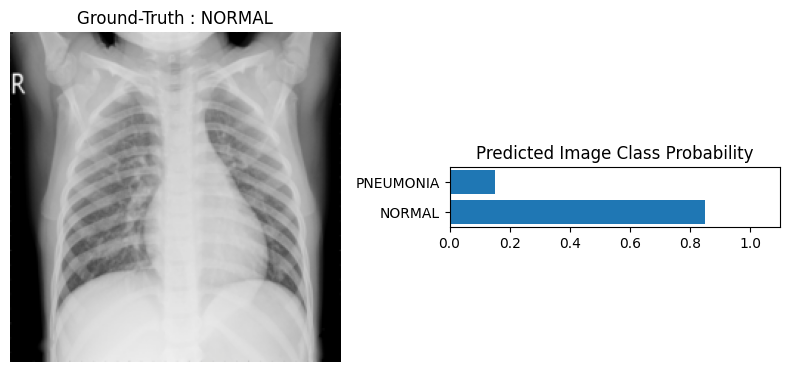

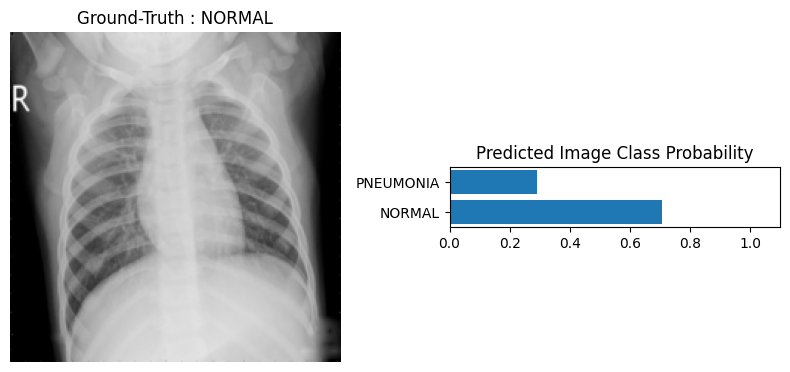

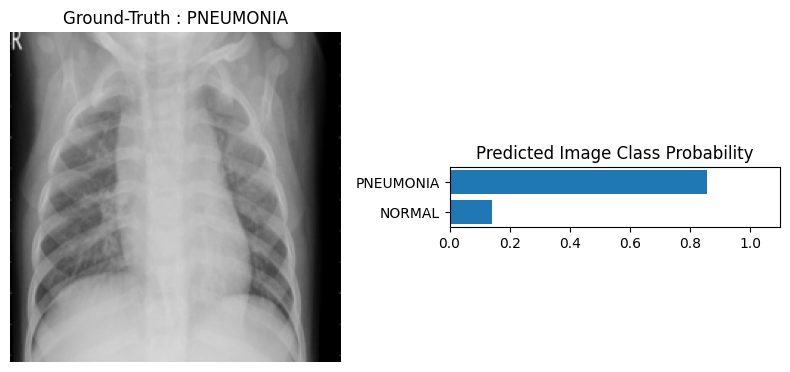

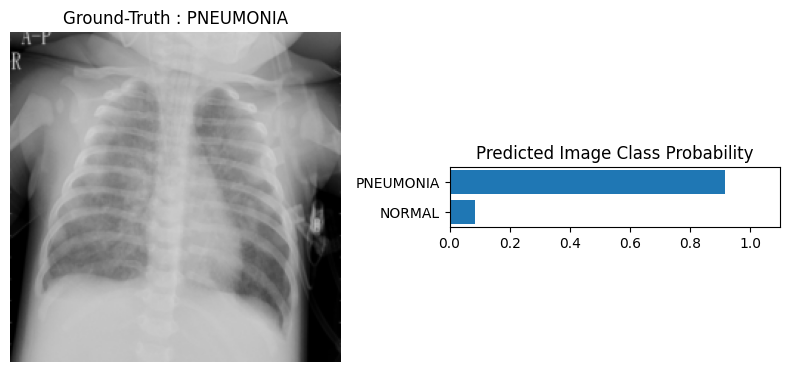

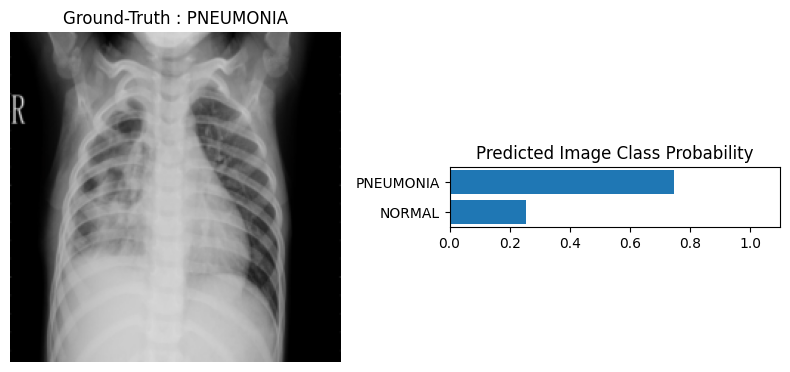

In [23]:
idx = 2
view_inference(idx)

idx = 5
view_inference(idx)

idx = 10
view_inference(idx)

idx = 14
view_inference(idx)

idx = 15
view_inference(idx)